# **Projeto de Análise da Bíblia em Português - NLP**

### Neste projeto, meu objetivo foi aplicar técnicas de Processamento de Linguagem Natural (PLN) para analisar o texto da Bíblia em português. Utilizei diferentes abordagens para extrair insights, identificar padrões e explorar as relações semânticas presentes nesse texto.

In [3]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall gensim

In [2]:
!pip install sumy

  Using cached sumy-0.11.0-py2.py3-none-any.whl.metadata (7.5 kB)
  Using cached docopt-0.6.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Using cached breadability-0.1.20.tar.gz (32 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21692 sha256=c8c5e45bf37c5cb096171863ce7ca62a72eef04b8773a466b5df9a8ac994922e
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1be69bd80fe3a345d7777e8b73d243f8784fc573dae3e690a2ef3fb8210d1d0d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [3]:
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

# importar modulos summy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import os

In [6]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
# Baixar recursos NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Carregar o modelo de linguagem em português do spaCy
nlp = spacy.load('pt_core_news_sm')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
# Definir o caminho do arquivo JSON
json_file_path = '/content/drive/MyDrive/dados_projetos/biblia/json/aa.json'



In [9]:
import json
# Carregar o arquivo JSON
with open(json_file_path, 'r', encoding='utf-8-sig') as f:
    data = json.load(f)



In [10]:
#Estruturar os dados em um DataFrame
records = []

for book in data:
    book_name = book['name']  # Ajustado de 'book' para 'name' conforme a estrutura do JSON
    chapters = book['chapters']
    for chapter_idx, chapter in enumerate(chapters):
        for verse_idx, verse_text in enumerate(chapter):
            record = {
                'book_name': book_name,
                'chapter': chapter_idx + 1,  # Índice começa em 0, então adicionamos 1
                'verse': verse_idx + 1,
                'text': verse_text
            }
            records.append(record)

# Criar o DataFrame
df = pd.DataFrame(records)

# Visualizar as primeiras linhas
df.head()



book_name  chapter  verse                                               text
0   Gênesis        1      1         No princípio criou Deus os céus e a terra.
1   Gênesis        1      2  A terra era sem forma e vazia; e havia trevas ...
2   Gênesis        1      3                 Disse Deus: haja luz. E houve luz.
3   Gênesis        1      4  Viu Deus que a luz era boa; e fez separação en...
4   Gênesis        1      5  E Deus chamou à luz dia, e às trevas noite. E ...

In [11]:
# Preprocessamento de texto usando lematização
# Definir o conjunto de stop words em português
stop_words = set(nltk.corpus.stopwords.words('portuguese'))

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Aplicar o preprocessamento ao texto
df['clean_text'] = df['text'].apply(preprocess_text)



In [12]:
# Modelagem de tópicos (considerando capítulos como documentos)
num_topics = 5  # Número de tópicos que você deseja extrair
topic_results = {}

for book_name, group in df.groupby('book_name'):
    # Agrupar os textos por capítulo
    chapter_texts = group.groupby('chapter')['clean_text'].apply(lambda x: ' '.join(x)).tolist()
    # Criar um corpus com os capítulos
    texts = [chapter.split() for chapter in chapter_texts]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # Aplicar LDA
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=5)
    topic_results[book_name] = topics




In [13]:
# Exibir os tópicos
for book, topics in topic_results.items():
    print(f"Tópicos para o livro {book}:\n")
    for topic_num, topic in topics:
        print(f"Tópico {topic_num}: {topic}\n")
    print("="*50)



Tópicos para o livro 1 Coríntios:

Tópico 0: 0.023*"falar" + 0.019*"língua" + 0.016*"amor" + 0.014*"ser" + 0.014*"igreja"

Tópico 1: 0.032*"corpo" + 0.024*"deus" + 0.020*"cristo" + 0.020*"haver" + 0.019*"ressuscitar"

Tópico 2: 0.040*"deus" + 0.023*"senhor" + 0.022*"mulher" + 0.020*"cristo" + 0.017*"marido"

Tópico 3: 0.026*"deus" + 0.024*"homem" + 0.022*"mulher" + 0.018*"senhor" + 0.014*"ser"

Tópico 4: 0.017*"lei" + 0.015*"senhor" + 0.015*"coisa" + 0.012*"evangelho" + 0.012*"de"

Tópicos para o livro 1 Crônicas:

Tópico 0: 0.089*"filho" + 0.014*"pai" + 0.013*"irmão" + 0.012*"casa" + 0.012*"campo"

Tópico 1: 0.058*"filho" + 0.019*"casa" + 0.016*"senhor" + 0.015*"davi" + 0.012*"rei"

Tópico 2: 0.001*"filho" + 0.001*"senhor" + 0.001*"davi" + 0.001*"chefe" + 0.001*"casa"

Tópico 3: 0.035*"davi" + 0.032*"filho" + 0.030*"senhor" + 0.018*"israel" + 0.018*"deus"

Tópico 4: 0.073*"filho" + 0.022*"pai" + 0.008*"príncipe" + 0.007*"nome" + 0.007*"reinar"

Tópicos para o livro 1 João:

Tópico 0: 

In [14]:
# Geração de resumos usando o texto original
summarizer = LexRankSummarizer()

book_summaries = {}

for book_name, group in df.groupby('book_name'):
    # Concatenar o texto original de todos os versículos do livro
    text = ' '.join(group['text'])
    # Criar um parser
    parser = PlaintextParser.from_string(text, Tokenizer('portuguese'))
    # Gerar o resumo (por exemplo, 5 sentenças)
    summary = summarizer(parser.document, sentences_count=5)
    summary_text = ' '.join([str(sentence) for sentence in summary])
    book_summaries[book_name] = summary_text


In [15]:
# Exibir os resumos
for book, summary in book_summaries.items():
    print(f"Resumo do livro {book}:\n")
    print(f"{summary}\n")
    print("="*50)



Resumo do livro 1 Coríntios:

Sempre dou graças a Deus por vós, pela graça de Deus que vos foi dada em Cristo Jesus; porque em tudo fostes enriquecidos nele, em toda palavra e em todo o conhecimento, assim como o testemunho de Cristo foi confirmado entre vós; de maneira que nenhum dom vos falta, enquanto aguardais a manifestação de nosso Senhor Jesus Cristo, o qual também vos confirmará até o fim, para serdes irrepreensíveis no dia de nosso Senhor Jesus Cristo. Mas o corpo não é para a prostituição, mas para o Senhor, e o Senhor para o corpo. Pois, ainda que haja também alguns que se chamem deuses, quer no céu quer na terra {como há muitos deuses e muitos senhores}, todavia para nós há um só Deus, o Pai, de quem são todas as coisas e para quem nós vivemos; e um só Senhor, Jesus Cristo, pelo qual existem todas as coisas, e por ele nós também. De modo que qualquer que comer do pão, ou beber do cálice do Senhor indignamente, será culpado do corpo e do sangue do Senhor. E agora, irmãos, se

### Análise Exploratória de Dados

In [16]:
# Contagem das palavras mais frequentes por livro e no total
def get_word_frequencies(text):
    tokens = text.split()
    return Counter(tokens)

# Frequências de palavras por livro
word_frequencies_by_book = {}

for book_name, group in df.groupby('book_name'):
    # Concatenar o texto limpo de todos os versículos do livro
    text = ' '.join(group['clean_text'])
    # Obter as frequências das palavras
    frequencies = get_word_frequencies(text)
    # Obter as N palavras mais comuns (por exemplo, 10)
    most_common = frequencies.most_common(10)
    word_frequencies_by_book[book_name] = most_common



In [17]:
# Frequências de palavras no total
# Concatenar o texto limpo de todos os versículos
total_text = ' '.join(df['clean_text'])
total_frequencies = get_word_frequencies(total_text)
total_most_common = total_frequencies.most_common(20)  # Top 20 palavras mais comuns



In [18]:
# Exibir as palavras mais frequentes por livro
for book, frequencies in word_frequencies_by_book.items():
    print(f"Palavras mais frequentes no livro {book}:\n")
    for word, count in frequencies:
        print(f"{word}: {count}")
    print("="*50)


Palavras mais frequentes no livro 1 Coríntios:

deus: 105
senhor: 70
cristo: 63
ser: 58
coisa: 50
homem: 47
corpo: 47
haver: 43
mulher: 40
espírito: 39
Palavras mais frequentes no livro 1 Crônicas:

filho: 665
senhor: 178
davi: 177
casa: 132
deus: 117
israel: 115
pai: 111
chefe: 101
irmão: 97
rei: 74
Palavras mais frequentes no livro 1 João:

deus: 65
ele: 30
filho: 27
em: 24
mundo: 23
amor: 19
amar: 18
permanecer: 17
vida: 16
irmão: 15
Palavras mais frequentes no livro 1 Pedro:

deus: 39
cristo: 22
ser: 20
glória: 11
jesus: 9
espírito: 9
senhor: 9
graça: 8
amor: 8
santo: 7
Palavras mais frequentes no livro 1 Reis:

rei: 291
senhor: 289
dizer: 213
israel: 201
filho: 181
casa: 180
salomão: 152
deus: 102
pai: 90
haver: 86
Palavras mais frequentes no livro 1 Samuel:

senhor: 356
saul: 303
davi: 286
dizer: 285
homem: 160
israel: 143
samuel: 133
filho: 130
filisteu: 121
mão: 104
Palavras mais frequentes no livro 1 Tessalonicenses:

deus: 37
senhor: 24
irmão: 18
jesus: 16
ser: 12
cristo: 10


In [19]:
# Exibir as palavras mais frequentes no total
print("Palavras mais frequentes em toda a Bíblia:\n")
for word, count in total_most_common:
    print(f"{word}: {count}")



Palavras mais frequentes em toda a Bíblia:

senhor: 8045
filho: 5094
deus: 4598
dizer: 4041
ser: 3568
terra: 3020
homem: 2918
rei: 2786
de: 2632
israel: 2541
haver: 2473
dia: 2385
casa: 2221
ter: 2023
ele: 1892
mão: 1627
pai: 1607
eu: 1418
se: 1401
palavra: 1341


<ipython-input-20-cbb51778343c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


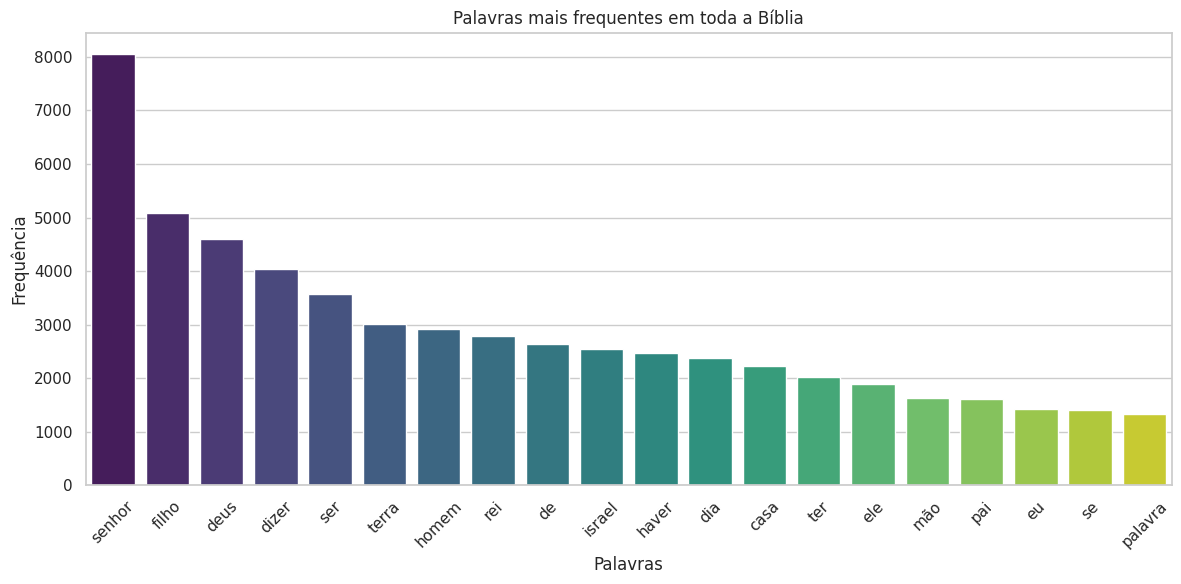

In [20]:
# Plotar gráficos das palavras mais frequentes
sns.set(style='whitegrid')

# Gráfico das palavras mais frequentes no total
words, counts = zip(*total_most_common)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title('Palavras mais frequentes em toda a Bíblia')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# # Plotar gráficos das palavras mais frequentes por livro e salvar
# # Certifique-se de que o diretório existe
# results_dir = '/content/drive/MyDrive/dados_projetos/biblia/resultados/'
# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)

# for book_name, frequencies in word_frequencies_by_book.items():
#     words, counts = zip(*frequencies)

#     plt.figure(figsize=(12, 6))
#     sns.barplot(x=list(words), y=list(counts), palette='viridis')
#     plt.title(f'Palavras mais frequentes no livro {book_name}')
#     plt.xlabel('Palavras')
#     plt.ylabel('Frequência')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     # Salvar o gráfico
#     plt.savefig(f'{results_dir}{book_name}_frequencias.png')
#     plt.close()


<ipython-input-21-b713c0a963bc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')
<ipython-input-21-b713c0a963bc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')
<ipython-input-21-b713c0a963bc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')
<ipython-input-21-b713c0a963bc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

In [22]:
# Salvar os tópicos e resumos

# Salvar tópicos
output_topics_path = os.path.join(results_dir, 'topicos.txt')

with open(output_topics_path, 'w', encoding='utf-8') as f:
    for book, topics in topic_results.items():
        f.write(f"Tópicos para o livro {book}:\n")
        for topic_num, topic in topics:
            f.write(f"Tópico {topic_num}: {topic}\n")
        f.write("="*50 + "\n")

# Salvar resumos
output_summaries_path = os.path.join(results_dir, 'resumos.txt')

with open(output_summaries_path, 'w', encoding='utf-8') as f:
    for book, summary in book_summaries.items():
        f.write(f"Resumo do livro {book}:\n")
        f.write(f"{summary}\n")
        f.write("="*50 + "\n")


In [23]:
# Treinar embeddings de palavras usando Word2Vec
from gensim.models import Word2Vec



In [24]:
# Preparar os textos para treinamento
sentences = df['clean_text'].apply(lambda x: x.split()).tolist()



In [25]:
# Treinar o modelo Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)




In [26]:
# Obter o vocabulário
vocab = list(word2vec_model.wv.key_to_index.keys())



In [27]:
# Selecionar as N palavras mais frequentes
N = 200  # Ajuste conforme necessário
# Obter as palavras mais frequentes
total_frequencies = get_word_frequencies(total_text)
most_common_words = [word for word, count in total_frequencies.most_common(N)]



In [28]:
# Filtrar o vocabulário e os vetores
vocab_filtered = [word for word in vocab if word in most_common_words]
word_vectors_filtered = word2vec_model.wv[vocab_filtered]



In [29]:
# Aplicar t-SNE para reduzir para 2 dimensões
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
word_embeddings_2d = tsne.fit_transform(word_vectors_filtered)



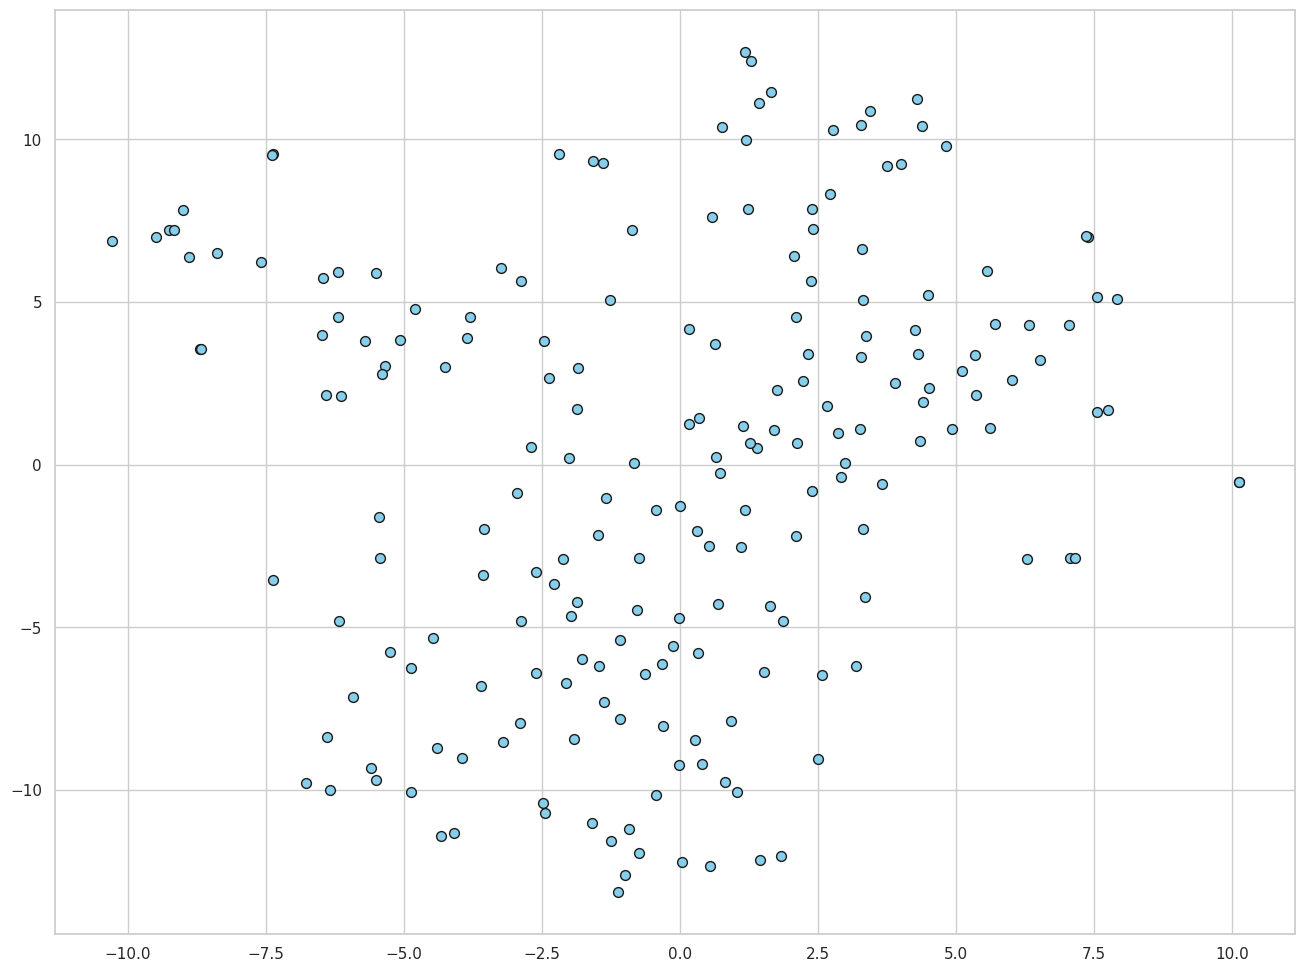

In [30]:
# Plotar o gráfico de dispersão das palavras
plt.figure(figsize=(16, 12))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], s=50, edgecolors='k', c='skyblue')



In [31]:
# Adicionar as palavras ao gráfico
for i, word in enumerate(vocab_filtered):
    plt.text(word_embeddings_2d[i, 0]+0.05, word_embeddings_2d[i, 1]+0.05, word, fontsize=9)

plt.title('Gráfico de Dispersão de Palavras - Embeddings Word2Vec + t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)



In [32]:
# Salvar o gráfico
plt.savefig(f'{results_dir}dispersao_palavras.png')
plt.show()

<Figure size 640x480 with 0 Axes>

In [33]:
import plotly.express as px

fig = px.scatter(x=word_embeddings_2d[:, 0], y=word_embeddings_2d[:, 1], text=vocab_filtered)
fig.update_traces(textposition='top center')
fig.update_layout(title='Gráfico de Dispersão de Palavras - Embeddings Word2Vec + t-SNE')
fig.show()


In [34]:
# Atualizar a biblioteca sentence-transformers
!pip install -U sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.5 MB/s eta 0:00:00


In [35]:
# Bibliotecas para modelos de linguagem e embeddings

from sentence_transformers import SentenceTransformer, util

import torch


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [36]:
# Carregar o modelo de embeddings de sentenças

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [37]:
# Obter a lista de versículos
verses = df['text'].tolist()


In [38]:

# Gerar os embeddings
embeddings = model.encode(verses, convert_to_tensor=True, show_progress_bar=True)


Batches:   0%|          | 0/972 [00:00<?, ?it/s]

In [39]:
# Definir a função para encontrar versículos semelhantes por índice
def find_similar_verses(verse_index, top_k=5):
    # Obter o embedding do versículo de interesse
    query_embedding = embeddings[verse_index]

    # Calcular a similaridade coseno entre o embedding de consulta e todos os outros embeddings
    cosine_scores = util.cos_sim(query_embedding, embeddings)[0]

    # Obter os índices dos versículos mais semelhantes
    top_results = torch.topk(cosine_scores, k=top_k+1)  # +1 porque o próprio versículo será o mais semelhante

    print(f"Versículo de referência:\n")
    print(f"{df.iloc[verse_index]['book_name']} {df.iloc[verse_index]['chapter']}:{df.iloc[verse_index]['verse']} - {df.iloc[verse_index]['text']}\n")
    print("Versículos mais semelhantes:\n")

    for score, idx in zip(top_results[0][1:], top_results[1][1:]):  # Ignoramos o primeiro, que é o próprio versículo
        idx = int(idx)           # Converter idx para inteiro
        score = float(score)     # Converter score para float

        print(f"Similaridade: {score:.4f}")
        print(f"{df.iloc[idx]['book_name']} {df.iloc[idx]['chapter']}:{df.iloc[idx]['verse']} - {df.iloc[idx]['text']}\n")



In [40]:
# Exemplo de Uso da Função
# Encontrar versículos semelhantes ao primeiro versículo (índice 0).

find_similar_verses(verse_index=0, top_k=5)


Versículo de referência:

Gênesis 1:1 - No princípio criou Deus os céus e a terra.

Versículos mais semelhantes:

Similaridade: 0.8846
Gênesis 2:4 - Eis as origens dos céus e da terra, quando foram criados. No dia em que o Senhor Deus fez a terra e os céus

Similaridade: 0.7932
Provérbios 3:19 - O Senhor pela sabedoria fundou a terra; pelo entendimento estabeleceu o céu.

Similaridade: 0.7777
Isaías 42:5 - Assim diz Deus, o Senhor, que criou os céus e os desenrolou, e estendeu a terra e o que dela procede; que dá a respiração ao povo que nela está, e o espírito aos que andam nela.

Similaridade: 0.7509
Gênesis 1:17 - E Deus os pôs no firmamento do céu para alumiar a terra,

Similaridade: 0.7281
Salmos 90:2 - Antes que nascessem os montes, ou que tivesses formado a terra e o mundo, sim, de eternidade a eternidade tu és Deus.



In [41]:
# Definir a função para encontrar versículos semelhantes a um texto
def find_similar_verses_by_text(input_text, top_k=5):
    # Gerar o embedding do texto de entrada
    query_embedding = model.encode(input_text, convert_to_tensor=True)

    # Calcular a similaridade coseno com todos os embeddings dos versículos
    cosine_scores = util.cos_sim(query_embedding, embeddings)[0]

    # Obter os índices dos versículos mais semelhantes
    top_results = torch.topk(cosine_scores, k=top_k)

    print(f"Texto de referência:\n")
    print(f"{input_text}\n")
    print("Versículos mais semelhantes:\n")

    for score, idx in zip(top_results[0], top_results[1]):
        idx = int(idx)           # Converter idx para inteiro
        score = float(score)     # Converter score para float

        print(f"Similaridade: {score:.4f}")
        print(f"{df.iloc[idx]['book_name']} {df.iloc[idx]['chapter']}:{df.iloc[idx]['verse']} - {df.iloc[idx]['text']}\n")



In [42]:
# Exemplo de uso da função com texto arbitrário
input_text = "Amar ao próximo como a si mesmo"
find_similar_verses_by_text(input_text, top_k=5)


Texto de referência:

Amar ao próximo como a si mesmo

Versículos mais semelhantes:

Similaridade: 0.6960
Mateus 22:39 - E o segundo, semelhante a este, é: Amarás ao teu próximo como a ti mesmo.

Similaridade: 0.6787
Tiago 2:8 - Todavia, se estais cumprindo a lei real segundo a escritura: Amarás ao teu próximo como a ti mesmo, fazeis bem.

Similaridade: 0.6748
Gálatas 5:14 - Pois toda a lei se cumpre numa só palavra, a saber: Amarás ao teu próximo como a ti mesmo.

Similaridade: 0.6624
Mateus 19:19 - honra a teu pai e a tua mãe; e amarás o teu próximo como a ti mesmo.

Similaridade: 0.6518
Levítico 19:18 - Não te vingarás nem guardarás ira contra os filhos do teu povo; mas amarás o teu próximo como a ti mesmo. Eu sou o Senhor.



In [43]:

# Visualização opcional com UMAP
!pip install umap-learn
import umap

# Converter embeddings para numpy
embeddings_np = embeddings.cpu().numpy()

# Aplicar UMAP para reduzir para 2 dimensões
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_np)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



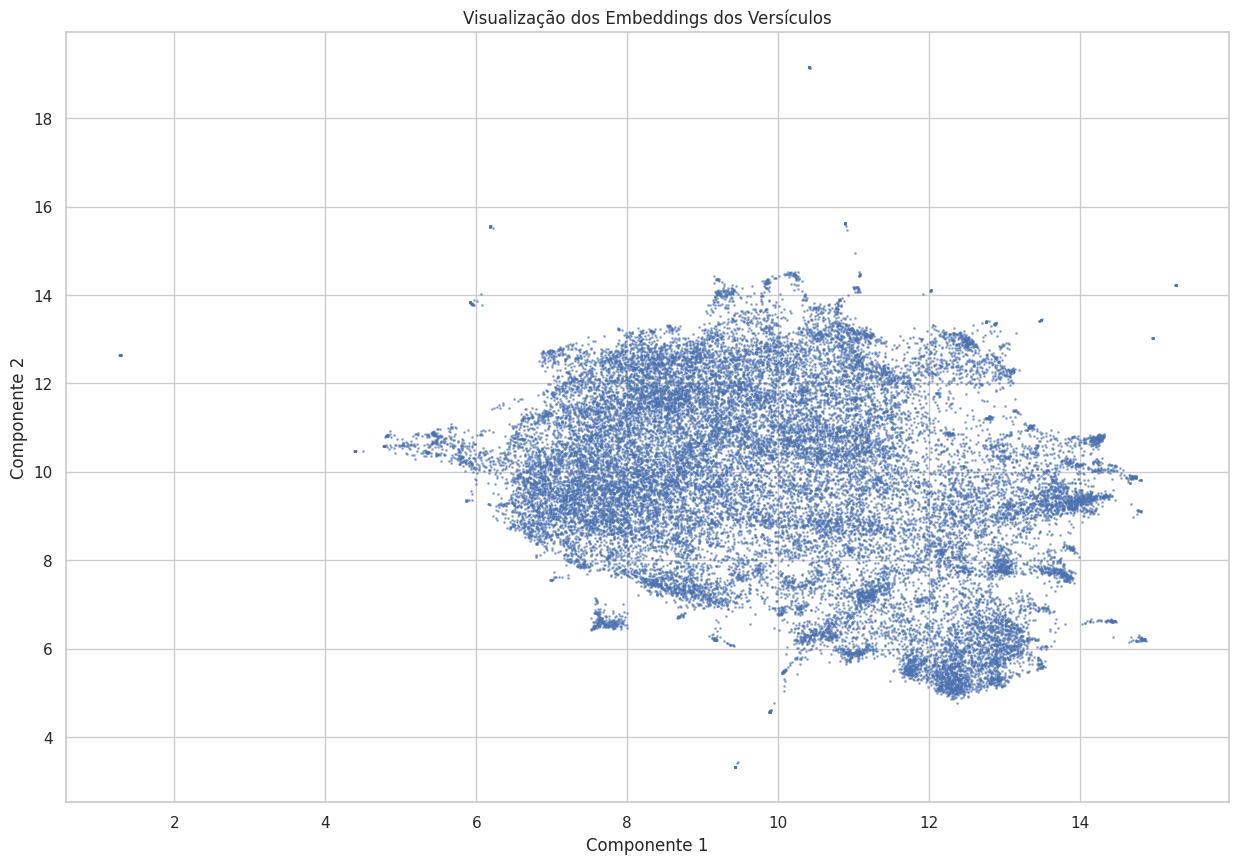

In [44]:
# Plotar os embeddings
plt.figure(figsize=(15, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.5)
plt.title('Visualização dos Embeddings dos Versículos')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

# Gráfico de dispersão dos embeddings dos versículos ou capítulos, destacando os tópicos gerais.

In [45]:
# Verificar os embeddings
print("Verificando os embeddings...")
print("Forma dos embeddings:", embeddings_np.shape)
print("Primeiros 5 embeddings:\n", embeddings_np[:5])


Verificando os embeddings...
Forma dos embeddings: (31104, 384)
Primeiros 5 embeddings:
 [[-0.04016082  0.370465   -0.09790456 ...  0.16676566  0.24064021
   0.00493657]
 [ 0.03488449  0.27698222  0.31347063 ...  0.07084918  0.17874227
   0.02662672]
 [-0.1280322   0.6025086   0.09994647 ...  0.14596377  0.28537485
   0.14659014]
 [-0.17904635  0.52777505  0.02667807 ...  0.1150073   0.22425772
   0.3451977 ]
 [-0.05546041  0.64027107 -0.07637702 ...  0.1929813   0.04502252
  -0.06153309]]


In [46]:
# Re-treinar o modelo LDA nos versículos
from gensim import corpora
from gensim.models import LdaModel

# Preparar os textos dos versículos
texts = [text.split() for text in df['clean_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Definir o número de tópicos
num_topics = 5  # Ajuste conforme necessário

# Treinar o modelo LDA
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Imprimir os tópicos para verificação
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx}: {topic}\n")




Tópico 0: 0.024*"ser" + 0.016*"dia" + 0.014*"amor" + 0.013*"ano" + 0.011*"morto" + 0.011*"homem" + 0.010*"corpo" + 0.010*"ter" + 0.009*"ouro" + 0.009*"trono"

Tópico 1: 0.035*"senhor" + 0.033*"dizer" + 0.032*"jesus" + 0.023*"deus" + 0.021*"palavra" + 0.021*"cristo" + 0.019*"dia" + 0.014*"falar" + 0.013*"ouvir" + 0.011*"fé"

Tópico 2: 0.061*"filho" + 0.018*"irmão" + 0.014*"ser" + 0.013*"de" + 0.012*"sacerdote" + 0.011*"discípulo" + 0.011*"casa" + 0.011*"alguém" + 0.010*"ter" + 0.007*"pai"

Tópico 3: 0.040*"deus" + 0.030*"senhor" + 0.019*"ser" + 0.016*"de" + 0.016*"terra" + 0.013*"ele" + 0.013*"coisa" + 0.012*"haver" + 0.010*"homem" + 0.010*"mão"

Tópico 4: 0.031*"rei" + 0.019*"cidade" + 0.014*"terra" + 0.013*"jerusalém" + 0.012*"casa" + 0.012*"se" + 0.009*"homem" + 0.009*"ter" + 0.009*"filho" + 0.009*"israel"



In [47]:
# Função para obter o tópico dominante de um documento
def get_dominant_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow, minimum_probability=0)
    topics = sorted(topics, key=lambda x: x[1], reverse=True)
    return topics[0][0]  # Retorna o tópico com a maior probabilidade

# Atribuir o tópico dominante a cada versículo
dominant_topics = []

for bow in corpus:
    dominant_topic = get_dominant_topic(lda_model, bow)
    dominant_topics.append(dominant_topic)

# Adicionar a lista ao DataFrame
df['dominant_topic'] = dominant_topics

# Verificar se há valores nulos
print("Número de valores nulos em dominant_topic:", df['dominant_topic'].isnull().sum())



Número de valores nulos em dominant_topic: 0


In [48]:
# Reduzir a dimensionalidade dos embeddings
import umap

# Converter embeddings para numpy (se ainda não estiverem)
if isinstance(embeddings, torch.Tensor):
    embeddings_np = embeddings.cpu().numpy()
else:
    embeddings_np = embeddings

# Aplicar UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_np)

# Verificar os embeddings reduzidos
print("Forma dos embeddings reduzidos:", embeddings_2d.shape)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Forma dos embeddings reduzidos: (31104, 2)


Cabeçalho do plot_df:
            x          y topic topic_name
0   7.792116   8.713339     3   Tópico 3
1  11.419580  12.033408     3   Tópico 3
2   7.633018   8.489539     3   Tópico 3
3   7.635042   8.518934     0   Tópico 0
4   9.306407  13.767546     1   Tópico 1
Tipos de dados em plot_df:
 x             float32
y             float32
topic          object
topic_name     object
dtype: object


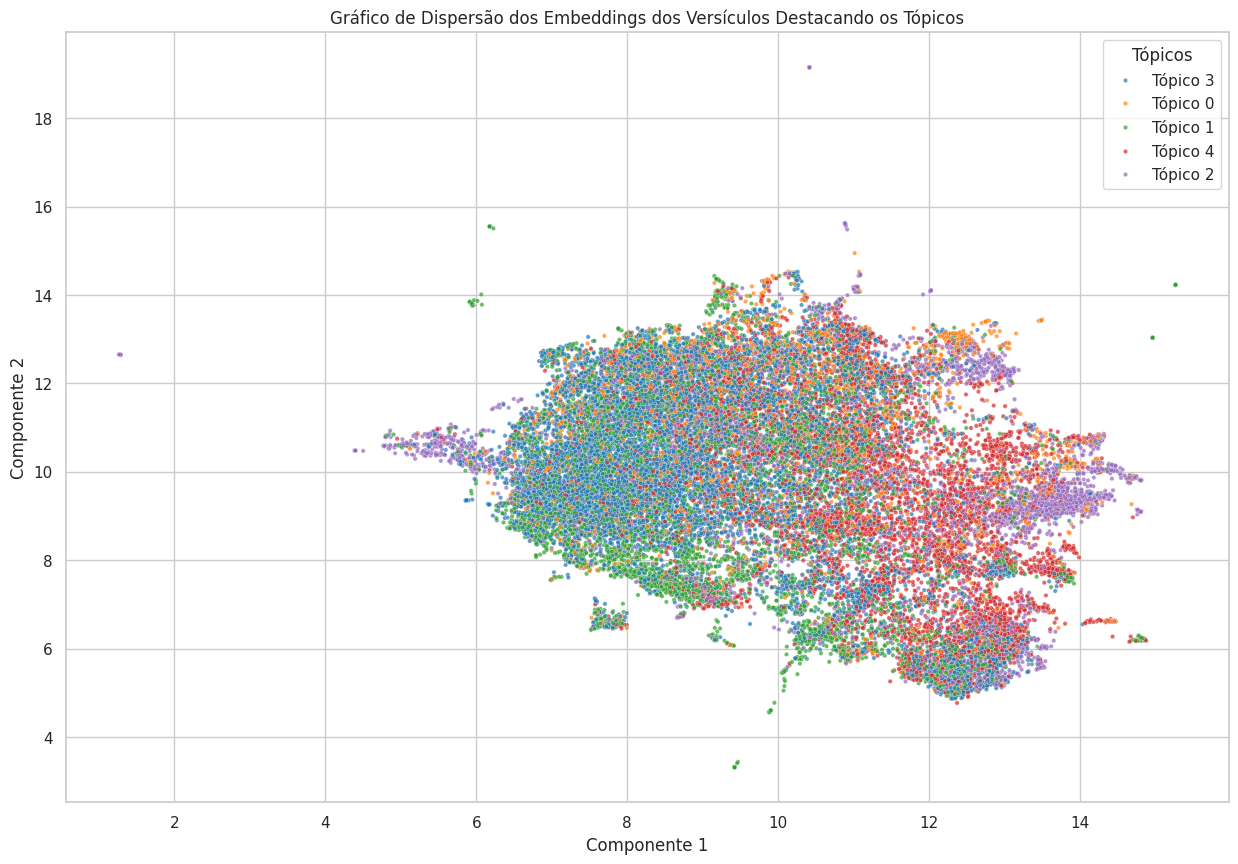

In [49]:
# Plotar o gráfico de dispersão
import matplotlib.pyplot as plt
import seaborn as sns

# Criar um DataFrame com os dados para plotagem
plot_df = pd.DataFrame()
plot_df['x'] = embeddings_2d[:, 0]
plot_df['y'] = embeddings_2d[:, 1]
plot_df['topic'] = df['dominant_topic'].astype(str)  # Converter para string para fins de plotagem

# Mapear os números dos tópicos para nomes
topic_names = {
    0: 'Tópico 0',
    1: 'Tópico 1',
    2: 'Tópico 2',
    3: 'Tópico 3',
    4: 'Tópico 4'
}
plot_df['topic_name'] = plot_df['topic'].astype(int).map(topic_names)

# Verificar o DataFrame de plotagem
print("Cabeçalho do plot_df:\n", plot_df.head())
print("Tipos de dados em plot_df:\n", plot_df.dtypes)

# Plotar o gráfico
plt.figure(figsize=(15, 10))
sns.scatterplot(
    data=plot_df,
    x='x',
    y='y',
    hue='topic_name',
    palette='tab10',
    s=10,
    alpha=0.7
)

plt.title('Gráfico de Dispersão dos Embeddings dos Versículos Destacando os Tópicos')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Tópicos')
plt.show()


# Análise de Rede de Coocorrência

In [51]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [52]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from pyvis.network import Network


In [53]:
nlp = spacy.load('pt_core_news_sm')


In [54]:
# Extrair Entidades Nomeadas dos Versículos

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['PER', 'LOC', 'ORG']]
    return entities


In [55]:
# Aplicar a função ao DataFrame
df['entities'] = df['text'].apply(extract_entities)
df[['text', 'entities']].head()


text            entities
0         No princípio criou Deus os céus e a terra.                  []
1  A terra era sem forma e vazia; e havia trevas ...  [Espírito de Deus]
2                 Disse Deus: haja luz. E houve luz.                  []
3  Viu Deus que a luz era boa; e fez separação en...          [Viu Deus]
4  E Deus chamou à luz dia, e às trevas noite. E ...              [Deus]

In [56]:
# Criar uma lista de todas as entidades

all_entities = df['entities'].tolist()


In [57]:
cooccurrences = []

for entities in all_entities:
    # Remover duplicatas dentro do mesmo versículo
    unique_entities = list(set(entities))
    # Gerar todas as combinações possíveis de coocorrências
    if len(unique_entities) > 1:
        cooccurrences.extend(list(combinations(unique_entities, 2)))


In [58]:
# Contar as frequências das coocorrências
cooccurrence_counts = Counter(cooccurrences)


In [59]:
# Construir o grafo de coocorrência
G = nx.Graph()

# Adicionar as arestas e seus pesos (frequência de coocorrência)
for (entity1, entity2), weight in cooccurrence_counts.items():
    G.add_edge(entity1, entity2, weight=weight)


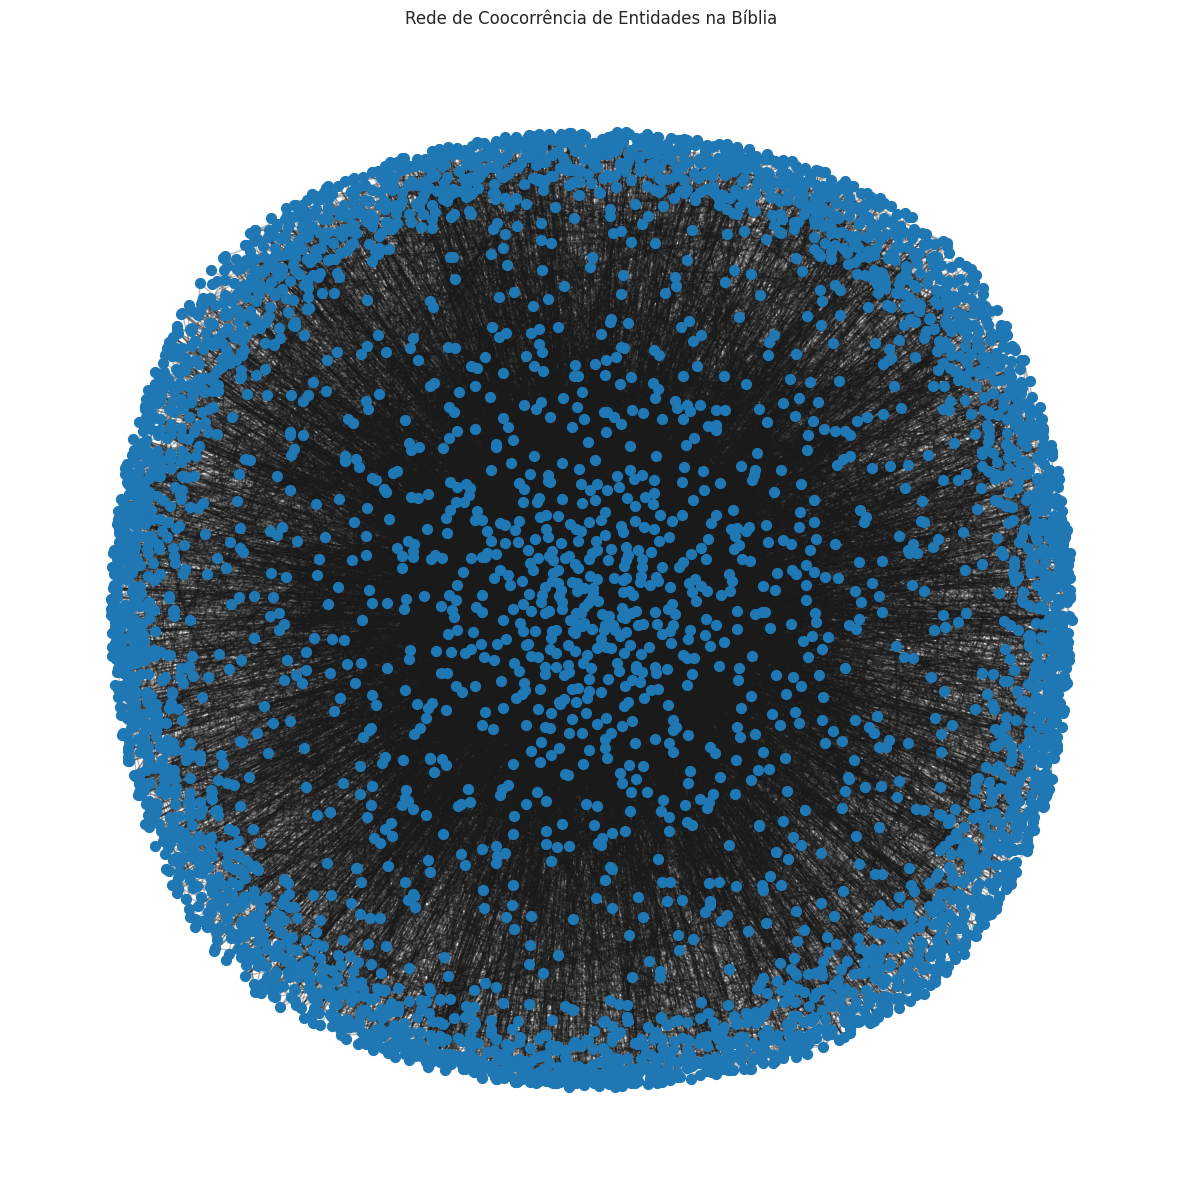

In [60]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.5)

# Desenhar os nós e arestas
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Adicionar rótulos aos nós (opcional)
# nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Rede de Coocorrência de Entidades na Bíblia')
plt.axis('off')
plt.show()


In [61]:
# Calcular o grau de cada nó
degree_dict = dict(G.degree(G.nodes()))

# Definir um limiar (por exemplo, nós com grau >= 4)
threshold = 4

# Criar um subgrafo com os nós que atendem ao critério
filtered_nodes = [node for node, degree in degree_dict.items() if degree >= threshold]
G_filtered = G.subgraph(filtered_nodes)


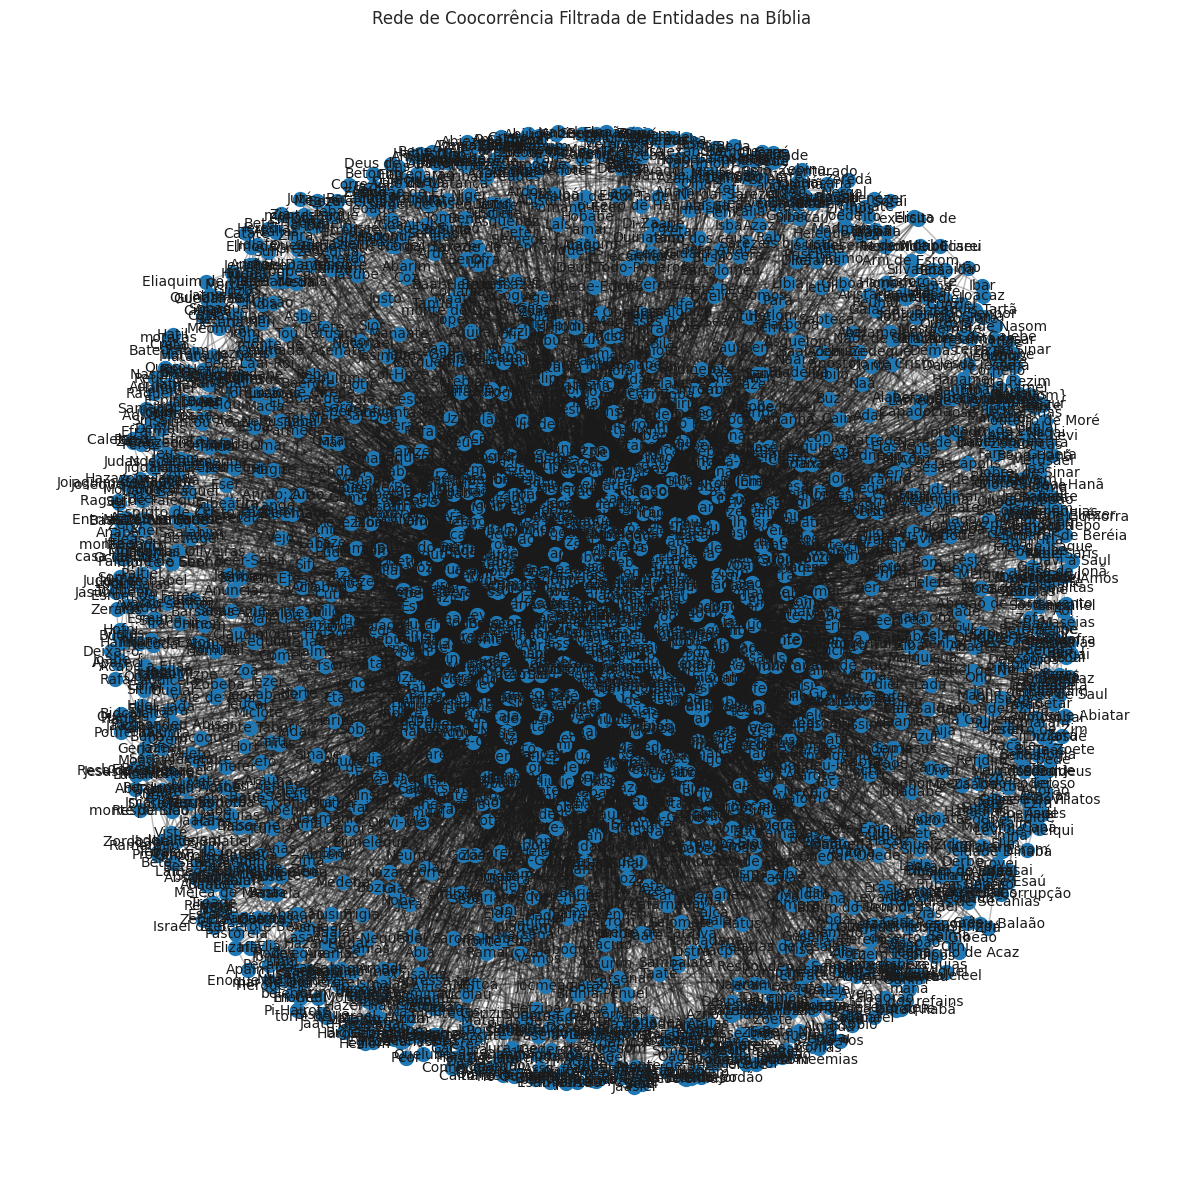

In [62]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_filtered, k=0.5)

nx.draw_networkx_nodes(G_filtered, pos, node_size=100)
nx.draw_networkx_edges(G_filtered, pos, alpha=0.3)
nx.draw_networkx_labels(G_filtered, pos, font_size=10)

plt.title('Rede de Coocorrência Filtrada de Entidades na Bíblia')
plt.axis('off')
plt.show()


#Análise da Rede

In [63]:
# Desinstalar o pacote 'community' se ele existir
!pip uninstall -y community

# Reinstalar o pacote 'python-louvain'
!pip install --force-reinstall --no-cache-dir python-louvain


Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Successfully uninstalled community-1.0.0b1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 133.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 67.2 MB/s eta 0:00:00
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9388 sha256=4f687c68a5da665f9560102f1e04422a780e111a3dcb223129a81ba4e5c5b4df
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gplgv45/wheels/d0/b0/d7/6dd26c3817810fa379088eaeb755a01d9a2a411c37632079d1
Successfully built python-louvain
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: networkx
    Fou

In [64]:
# Calcular a centralidade de grau
degree_centrality = nx.degree_centrality(G_filtered)

# Obter as top 5 entidades mais centrais
top_entities = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Entidades mais centrais na rede:")
for entity, centrality in top_entities:
    print(f"{entity}: {centrality:.4f}")


Entidades mais centrais na rede:
Senhor: 0.3154
Israel: 0.2517
Judá: 0.1803
Deus: 0.1535
Jerusalém: 0.1503


In [65]:
#  Limpar o cache de módulos importados
import sys
if 'community' in sys.modules:
    del sys.modules['community']

#  Importar o módulo corretamente
from community import community_louvain

# Executar o código para detectar comunidades
# Computar as comunidades
partition = community_louvain.best_partition(G_filtered)

# Adicionar a informação de comunidade aos nós
for node, community_id in partition.items():
    G_filtered.nodes[node]['community'] = community_id

# Número de comunidades detectadas
num_communities = len(set(partition.values()))
print(f"Número de comunidades detectadas: {num_communities}")


Número de comunidades detectadas: 25


<ipython-input-66-bc7322f21ebd>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



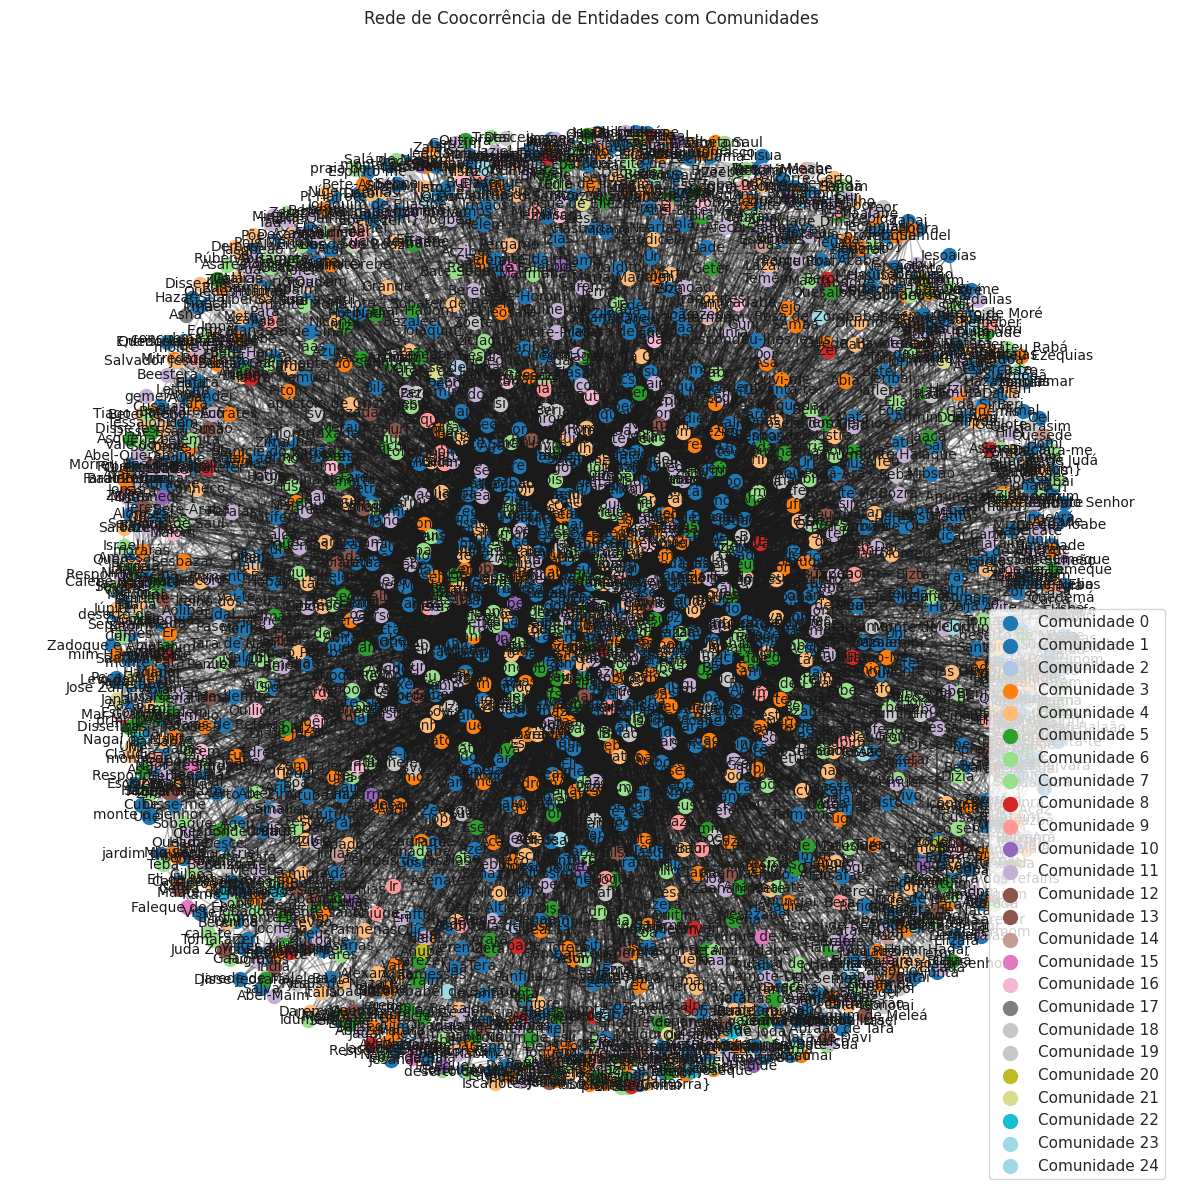

In [66]:
# Gerar uma lista de cores para as comunidades
import matplotlib.cm as cm
cmap = cm.get_cmap('tab20', num_communities)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_filtered, k=0.5, seed=42)

for community_id in set(partition.values()):
    nodes_in_community = [node for node in partition if partition[node] == community_id]
    nx.draw_networkx_nodes(G_filtered, pos, nodelist=nodes_in_community, node_size=100,
                           node_color=[cmap(community_id)], label=f'Comunidade {community_id}')

nx.draw_networkx_edges(G_filtered, pos, alpha=0.3)
nx.draw_networkx_labels(G_filtered, pos, font_size=10)

plt.title('Rede de Coocorrência de Entidades com Comunidades')
plt.legend()
plt.axis('off')
plt.show()


#Extração de Relações

In [67]:
# Definir Função para Extrair Relações
# Extrair relações sujeito-verbo-objeto usando análise sintática.

def extract_relations(text):
    doc = nlp(text)
    relations = []
    for sent in doc.sents:
        for token in sent:
            if token.dep_ == 'ROOT' and token.pos_ == 'VERB':
                subject = [w.text for w in token.lefts if w.dep_ in ['nsubj', 'nsubj_pass'] and w.ent_type_ in ['PER', 'LOC', 'ORG']]
                objects = [w.text for w in token.rights if w.dep_ in ['dobj', 'obj'] and w.ent_type_ in ['PER', 'LOC', 'ORG']]
                if subject and objects:
                    relations.append((subject[0], token.lemma_, objects[0]))
    return relations


In [68]:
df['relations'] = df['text'].apply(extract_relations)


In [69]:
# Coletar todas as relações
all_relations = []

for relations in df['relations']:
    all_relations.extend(relations)

# Criar um DataFrame com as relações
relations_df = pd.DataFrame(all_relations, columns=['Subject', 'Relation', 'Object'])


In [70]:
relations_df.head(10)


Subject  Relation    Object
0   Enoque    nascer     Irade
1      Ada       dar     Jabal
2    Cuche     gerar   Ninrode
3  Mizraim     gerar     Ludim
4    Canaã     gerar     Sidom
5    Joctã     gerar    Almodá
6   Senhor     dizer     Abrão
7    Abrão    descer     Egito
8       Ló  escolher  planície
9   Senhor   visitar      Sara

In [71]:
# Analisar as Relações
# Contar as relações mais comuns.

relation_counts = relations_df.groupby(['Subject', 'Relation', 'Object']).size().reset_index(name='Count')
relation_counts = relation_counts.sort_values(by='Count', ascending=False)

print("Relações mais comuns:")
relation_counts.head(10)


Relações mais comuns:


Subject   Relation     Object  Count
191  Senhor      dizer     Moisés      6
210  Senhor  ordenarar     Moisés      6
174  Samuel      dizer       Saul      3
179    Saul      dizer       Davi      3
50     Deus     enviar      Filho      2
158   Pedro      dizer      Jesus      2
38     Davi   derrotar  Hadadézer      2
90   Israel      dizer       José      2
39     Davi      dizer       Saul      2
203  Senhor      falar     Moisés      2

In [72]:
# Construir e visualizar um grafo das relações extraídas.

G_relations = nx.from_pandas_edgelist(relations_df, 'Subject', 'Object', edge_attr=True, create_using=nx.DiGraph())


In [73]:
# Filtrar nós com grau >= threshold
degree_dict = dict(G_relations.degree())
threshold = 3
filtered_nodes = [node for node, degree in degree_dict.items() if degree >= threshold]
G_relations_filtered = G_relations.subgraph(filtered_nodes)


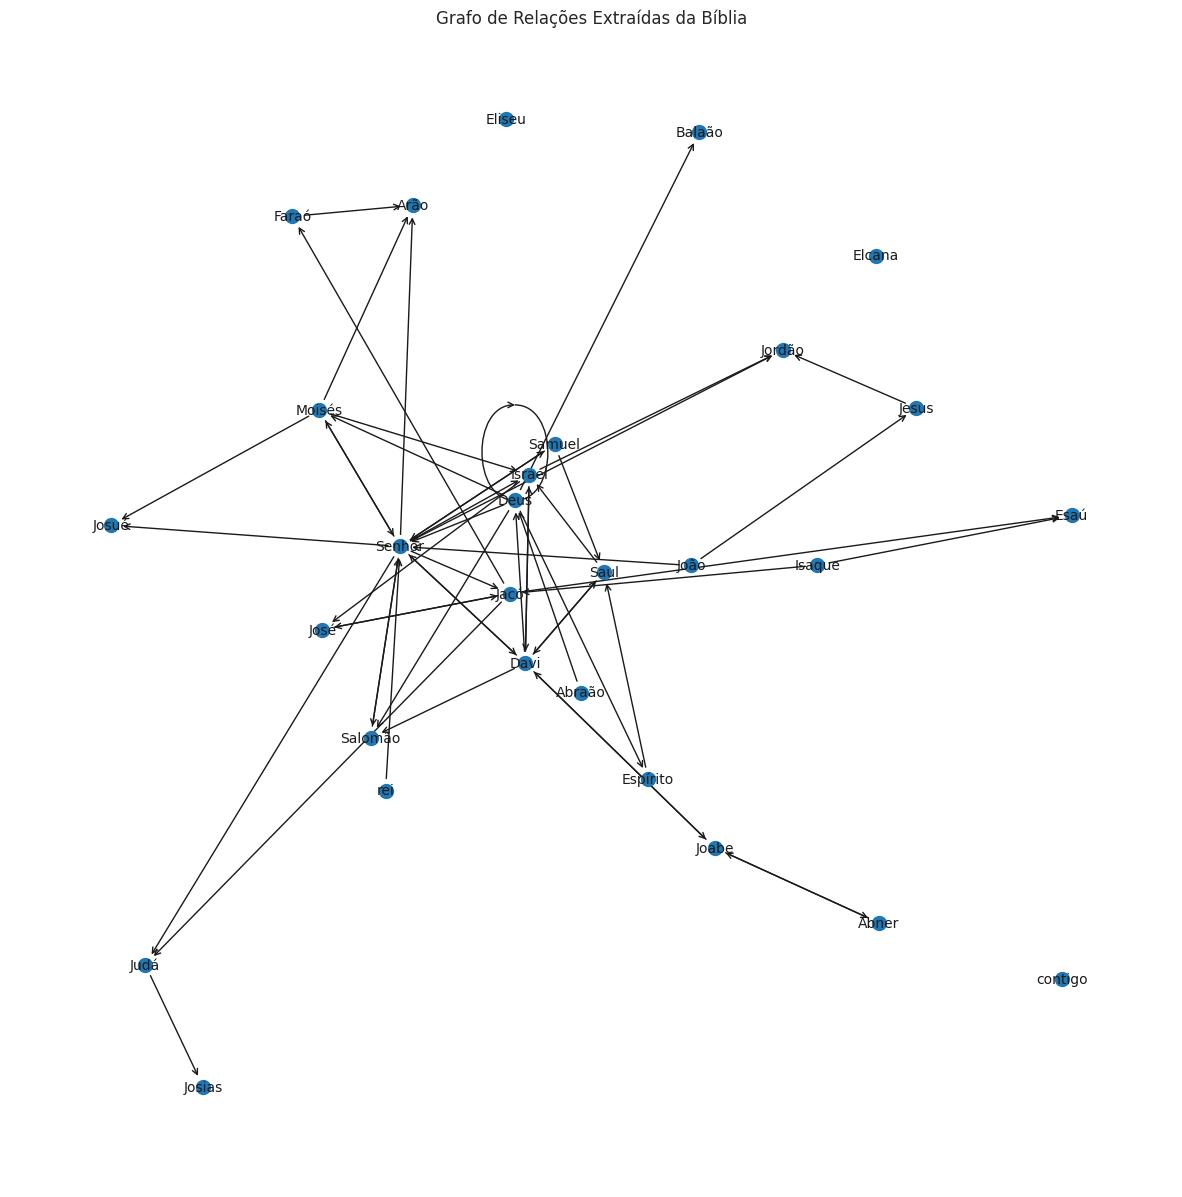

In [74]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_relations_filtered, k=0.5)

nx.draw_networkx_nodes(G_relations_filtered, pos, node_size=100)
nx.draw_networkx_edges(G_relations_filtered, pos, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G_relations_filtered, pos, font_size=10)

plt.title('Grafo de Relações Extraídas da Bíblia')
plt.axis('off')
plt.show()
